## Libraries/Data required

In [29]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score


# Import models
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

data_dir = "data/" # Define data path

In [30]:
df = pd.read_csv(data_dir + "food_crises_reg_imputed.csv") # Read data into DataFrame
# df["date"] = pd.to_datetime(df["year_month"], format="%Y_%m") # Create date column
print(len(df['district'].unique()))
df.set_index(["date", "district"], inplace=True) # Set index

78


<BR>

## Helper Functions

Here we define a function that lags input variables. There are options for creating a rolling mean, taking the difference between subsequent rows, and dropping NaNs. Feature engineering can of course be extended much further than this.

In [31]:
def create_lag_df(df, columns, lag, difference=False, rolling=None, dropna=False):
    '''
    Function to add lagged colums to dataframe
    
    Inputs:
        df - Dataframe
        columns - List of columns to create lags from
        lag - The number of timesteps (in months for the default data) to lag the variable by
        difference - Whether to take the difference between each observation as new column
        rolling - The size of the rolling mean window, input None type to not use a rolling variable
        dropna - Whether to drop NaN values
        
    Output:
        df - Dataframe with the lagged columns added
    '''
    
    for column in columns:
        col = df[column].unstack()
        if rolling:
            col = col.rolling(rolling).mean()
        if difference:
            col = col.diff()
        if dropna:
            col = col.dropna(how='any')
        df[f"{column}_lag_{lag}"] = col.shift(lag).stack()
    return df

<br>
Here we define a function that plots a confusion matrix given a prediction and the true values, it can be used both for binary and categorical variables.

In [32]:
def plot_ConfusionMatrix(prediction, true, binary=False):
    '''
    Function to plot a confusion matrix as a heatmap from a prediction and true values.
    
    Inputs:
        prediction - The predicted values
        true - the true values
        binary - whether the variable is binary or not
        
    Output:
        confusion_matrix - The calculated confusion matrix based on the prediction and true values.
        
        Also plots the confusion matrix as heatmap in an interactive environment such as Jupyter Notebook.
    '''
    
    y_pred = prediction
    
    if not binary:
        # Round prediction to nearest integer (i.e. the nearest phase)
        y_pred = y_pred.round() 
        y_pred = np.minimum(y_pred, 5) # Cap maximum prediction at 5 (maximum phase)
        y_pred = np.maximum(y_pred, 1) # Cap minimum prediction at 1 (minimum phase)

    # Initialize confusion matrix
    confusion_matrix = pd.crosstab(
        true, y_pred, rownames=["Actual"], colnames=["Predicted"]
    )

    # Plot confusion matrix as heatmap
    sns.heatmap(confusion_matrix, annot=True, fmt="g")
    plt.show()
    plt.clf()
    
    return confusion_matrix

## Making Predictions

To simplify, we treat the IPC prediction problem as regression rather than classification,
e.g., multivariable logistic regression might be more suited.
<br><br>
We use a TimeSeriesSplit to divide the data into 5 training-test splits and run cross-validation on these splits. 
<br>We report the confusion matrix (with training and test split as title) along with the model summary per split; the mean MAE and mean R2 are reported after completion of cross-validation.
<br><br>
First however, we create multiple lagged variables in the cell directly below.

In [33]:
# Create several lagged columns to use as explanatory variables for the model

df = create_lag_df(df, ['count_violence', 'ndvi_anom'], 3, rolling=6) # 3-month-lagged rolling mean window of size 6
df = create_lag_df(df, ['food_price_idx'], 3, difference=True, rolling=6) # difference of the 3-month-lagged rolling mean window of size 6
df = create_lag_df(df, ['ipc'], 1, dropna=True) # 1-month-lag
df = create_lag_df(df, ['ipc'], 2, dropna=True) # 2-month-lag
df = create_lag_df(df, ['ipc'], 3, dropna=True) # 3-month-lag

df.columns # View the newly created columns

Index(['country', 'district_code', 'centx', 'centy', 'year', 'month', 'ipc',
       'ha', 'ndvi_mean', 'ndvi_anom', 'rain_mean', 'rain_anom', 'et_mean',
       'et_anom', 'count_violence', 'sum_fatalities', 'food_price_idx', 'area',
       'cropland_pct', 'pop', 'ruggedness_mean', 'pasture_pct', 'province',
       'administrative_region', 'quarters', 'count_violence_lag_3',
       'ndvi_anom_lag_3', 'food_price_idx_lag_3', 'ipc_lag_1', 'ipc_lag_2',
       'ipc_lag_3'],
      dtype='object')

In [34]:
df.sort_index(level=0, inplace=True) # Sort DataFrame by date
df = df.iloc[df['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column

## Incorporating News Features

We look at country wide news features to simplify. E.g., we do not look at topics per district

In [35]:
news_df = pd.read_csv(data_dir + "articles_topics_extra_topics.csv") # Read news data into DataFrame

# Create date column
news_df["date"] = pd.to_datetime(
    pd.to_datetime(news_df["date"], format="%Y-%m-%d").dt.strftime("%Y-%m"),
    format="%Y-%m",
)

In [36]:
news_df[news_df["date"] > "2011-09-09"]

,summary,date,location_article,lat,lng,hunger,refugees,humanitarian,conflict,corruption,terrorism,nature,oil,livestock
765,The article discusses South Sudan's President ...,2011-10-01,Juba,4.859363,31.571250,False,False,False,False,True,False,False,False,False
766,The article discusses the escalation of violen...,2011-10-01,South Kordofan,11.036544,30.895824,False,False,False,False,False,False,False,False,False
767,The article discusses Sudan's president Omer a...,2011-10-01,Khartoum,15.500654,32.559899,False,False,False,False,False,False,False,False,False
768,The article discusses President Kiir directing...,2011-10-01,Juba,4.859363,31.571250,False,False,False,False,False,False,True,False,True
772,The article discusses the return of Lam Akol A...,2011-10-01,Juba International Airport,4.871189,31.602117,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18515,The article discusses the successful delivery ...,2023-04-01,Maiwut Primary Health Care Centre,8.606200,33.924100,False,False,False,False,False,False,False,False,False
18516,The article discusses the bombing and forced e...,2023-04-01,Khartoum,15.500654,32.559899,False,False,False,False,False,False,False,False,False
18517,The article discusses how Prime Minister Abiy ...,2023-04-01,Addis Ababa,8.980603,38.757761,False,False,False,False,False,False,False,False,False
18518,The article discusses the collapse of a commer...,2023-04-01,Kampala International University,0.294360,32.603970,False,False,False,True,False,False,False,False,False


In [37]:
def create_news_features(columns):
    cols = []
    for column in columns:
        col = news_df.groupby(["date"])[column].mean()
        col = col.fillna(0)
        col = col.rolling(3).mean()
        col = col.shift(3)
        cols.append(col)
    return pd.concat(cols, axis=1)

In [38]:
# country wide news features
news_features = create_news_features(["hunger", "refugees", "humanitarian", "conflict", "corruption", "terrorism", "nature", 'oil', "livestock"])

In [39]:
binary_classification = {False: 0, True: 1}
topics = ["hunger", "refugees", "humanitarian", "conflict", "corruption", "terrorism", "nature", 'oil', "livestock"]
for topic in topics:
    news_df[topic] = news_df[topic].map(binary_classification)

## Predicting using news features

In [40]:
df.sort_index(level=0, inplace=True) # Sort DataFrame by date
df = df.iloc[df['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column
df = df.join(news_features, how="left") # Join df with created news features

In [41]:
df.head()

country  district_code     centx     centy  year  \
date       district                                                             
2009-07-01 Abiemnhom     South Sudan            136  29.13019  9.550939  2009   
           Akobo         South Sudan            114  32.85308  7.799214  2009   
           Anzara        South Sudan             86  28.20598  5.309739  2009   
           Aweil Center  South Sudan            128  26.89562  8.417934  2009   
           Aweil East    South Sudan            141  27.61364  9.243139  2009   

                         month  ipc  ha  ndvi_mean  ndvi_anom  ...  ipc_lag_3  \
date       district                                            ...              
2009-07-01 Abiemnhom         7  2.0 NaN   0.698165   96.42507  ...        NaN   
           Akobo             7  4.0 NaN   0.474723   76.47572  ...        NaN   
           Anzara            7  1.0 NaN   0.812001  100.25750  ...        NaN   
           Aweil Center      7  2.0 NaN   0.723154   94.34696  ...        NaN   
           Aweil East        7  3.0 NaN   0.547611   86.30622  ...        NaN   

                         hunger  refugees  humanitarian  conflict  corruption  \
date       district                                                             
2009-07-01 Abiemnhom        NaN       NaN           NaN       NaN         NaN   
           Akobo            NaN       NaN           NaN       NaN         NaN   
           Anzara           NaN       NaN           NaN       NaN         NaN   
           Aweil Center     NaN       NaN           NaN       NaN         NaN   
           Aweil East       NaN       NaN           NaN       NaN         NaN   

                         terrorism  nature  oil  livestock  
date       district                                         
2009-07-01 Abiemnhom           NaN     NaN  NaN        NaN  
           Akobo               NaN     NaN  NaN        NaN  
           Anzara              NaN     NaN  NaN        NaN  
           Aweil Center        NaN     NaN  NaN        NaN  
           Aweil East          NaN     NaN  NaN        NaN  

[5 rows x 40 columns]

In [42]:
df['crisis'] = df['ipc'] >= 3.0
df['crisis'] = df['crisis'].map(binary_classification)
df.head()

country  district_code     centx     centy  year  \
date       district                                                             
2009-07-01 Abiemnhom     South Sudan            136  29.13019  9.550939  2009   
           Akobo         South Sudan            114  32.85308  7.799214  2009   
           Anzara        South Sudan             86  28.20598  5.309739  2009   
           Aweil Center  South Sudan            128  26.89562  8.417934  2009   
           Aweil East    South Sudan            141  27.61364  9.243139  2009   

                         month  ipc  ha  ndvi_mean  ndvi_anom  ...  hunger  \
date       district                                            ...           
2009-07-01 Abiemnhom         7  2.0 NaN   0.698165   96.42507  ...     NaN   
           Akobo             7  4.0 NaN   0.474723   76.47572  ...     NaN   
           Anzara            7  1.0 NaN   0.812001  100.25750  ...     NaN   
           Aweil Center      7  2.0 NaN   0.723154   94.34696  ...     NaN   
           Aweil East        7  3.0 NaN   0.547611   86.30622  ...     NaN   

                         refugees  humanitarian  conflict  corruption  \
date       district                                                     
2009-07-01 Abiemnhom          NaN           NaN       NaN         NaN   
           Akobo              NaN           NaN       NaN         NaN   
           Anzara             NaN           NaN       NaN         NaN   
           Aweil Center       NaN           NaN       NaN         NaN   
           Aweil East         NaN           NaN       NaN         NaN   

                         terrorism  nature  oil  livestock  crisis  
date       district                                                 
2009-07-01 Abiemnhom           NaN     NaN  NaN        NaN       0  
           Akobo               NaN     NaN  NaN        NaN       1  
           Anzara              NaN     NaN  NaN        NaN       0  
           Aweil Center        NaN     NaN  NaN        NaN       0  
           Aweil East          NaN     NaN  NaN        NaN       1  

[5 rows x 41 columns]

In [43]:
df['crisis'].value_counts()

0    1978
1    1064
Name: crisis, dtype: int64

In [44]:
df.isna().sum()

country                     0
district_code               0
centx                       0
centy                       0
year                        0
month                       0
ipc                         0
ha                        858
ndvi_mean                   0
ndvi_anom                   0
rain_mean                   0
rain_anom                   0
et_mean                     0
et_anom                     0
count_violence              0
sum_fatalities              0
food_price_idx              0
area                        0
cropland_pct                0
pop                         0
ruggedness_mean             0
pasture_pct                 0
province                    0
administrative_region       0
quarters                    0
count_violence_lag_3      624
ndvi_anom_lag_3           624
food_price_idx_lag_3      702
ipc_lag_1                  78
ipc_lag_2                 156
ipc_lag_3                 234
hunger                   3042
refugees                 3042
humanitari

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\missingpy\missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "
c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not 

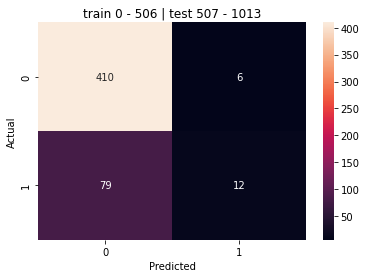

              precision    recall  f1-score   support

           0       0.84      0.99      0.91       416
           1       0.67      0.13      0.22        91

    accuracy                           0.83       507
   macro avg       0.75      0.56      0.56       507
weighted avg       0.81      0.83      0.78       507

Iteration: 0
Iteration: 1
Iteration: 2


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\missingpy\missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "
c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not 

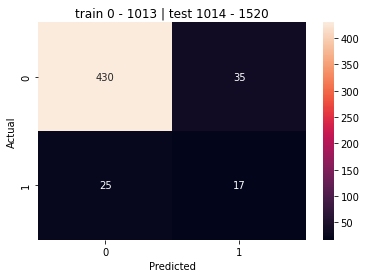

              precision    recall  f1-score   support

           0       0.95      0.92      0.93       465
           1       0.33      0.40      0.36        42

    accuracy                           0.88       507
   macro avg       0.64      0.66      0.65       507
weighted avg       0.89      0.88      0.89       507

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\missingpy\missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "
c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not 

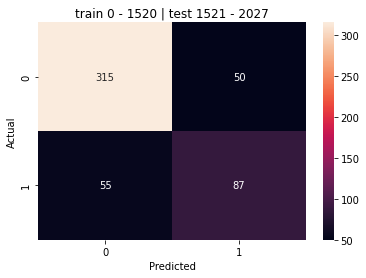

              precision    recall  f1-score   support

           0       0.85      0.86      0.86       365
           1       0.64      0.61      0.62       142

    accuracy                           0.79       507
   macro avg       0.74      0.74      0.74       507
weighted avg       0.79      0.79      0.79       507

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\missingpy\missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "
c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not 

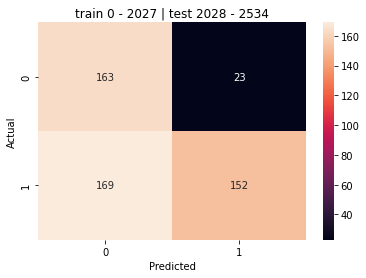

              precision    recall  f1-score   support

           0       0.49      0.88      0.63       186
           1       0.87      0.47      0.61       321

    accuracy                           0.62       507
   macro avg       0.68      0.67      0.62       507
weighted avg       0.73      0.62      0.62       507

Iteration: 0
Iteration: 1
Iteration: 2


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\missingpy\missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "
c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not 

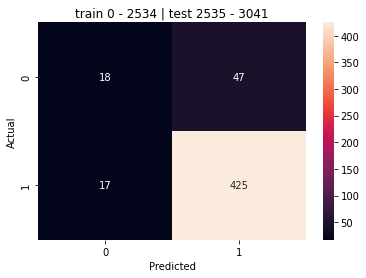

              precision    recall  f1-score   support

           0       0.51      0.28      0.36        65
           1       0.90      0.96      0.93       442

    accuracy                           0.87       507
   macro avg       0.71      0.62      0.64       507
weighted avg       0.85      0.87      0.86       507



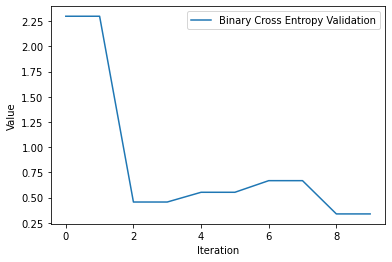

Mean Accuracy: 0.800394
[0.8323471400394478, 0.8816568047337278, 0.7928994082840237, 0.621301775147929, 0.873767258382643]


In [58]:
from sklearn.ensemble import RandomForestClassifier
import sklearn.neighbors._base
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import warnings
from sklearn.metrics import log_loss


# Specifying the warnings to be ignored
warnings.filterwarnings(
    action="ignore",
    message="Criterion 'mse'",
)
warnings.filterwarnings(
    action="ignore",
    message="`max_features='auto'`",
)

imputer = MissForest(verbose=0)
label_encoder = LabelEncoder()
df_copy = df.copy() # Make a copy of the original df
df_copy.ffill(inplace=True) # Data imputation using forward fill

X = df_copy.iloc[:, -16:-1] # Define explanatory variables
X = sm.add_constant(X) # Add constant column of 1s for intercept
y = df_copy[["crisis"]] # Define target data

cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits

# Initinalize empty lists to score scores
accuracy_values = list()
binary_cross_entropy_loss = list()
train_scores = list()
valid_scores = list()

for train_index, val_index in cv.split(X): # Loop over the different training-test splits

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # If X_train doesn't contain any news features (this happens for earlier dates) we drop news columns from both X_train and X_test
    X_train = X_train.dropna(axis=1, how='all').copy()
    X_test = X_test[X_train.columns]
    
    #Interpolate training data to generate more training points
    X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    X_train.reset_index(level=0, drop=True, inplace=True)
    y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    y_train.reset_index(level=0, drop=True, inplace=True)

    # Interpolate testing data using the same imputer as for training data
    X_train_imputed = imputer.fit_transform(X_train.values)
    X_test_imputed = imputer.fit_transform(X_test.values)

    # Train the RandomForestClassifier
    # number of trees is 100, and  42 is just to initialize random number to make random choices during training
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    results = rf_classifier.fit(X=X_train_imputed, y=np.ravel(y_train))

    rf_classifier.feature_names_in_ = list(X.columns)

    # Predict on the test data
    # Predict and calculate accuracy
    y_train_pred = rf_classifier.predict(X_train_imputed)
    y_pred = rf_classifier.predict(X_test_imputed)
    
    accuracy = accuracy_score(y_val, y_pred)
    accuracy_values.append(accuracy)

    pred_probabilities = rf_classifier.predict_proba(X_test_imputed)
    binary_cross_entropy_loss.append(log_loss(y_val, pred_probabilities))

    pred_probabilities = rf_classifier.predict_proba(X_test_imputed)
    binary_cross_entropy_loss.append(log_loss(y_val, pred_probabilities))
    
    train_scores.append(accuracy_score(y_train, y_train_pred))
    valid_scores.append(accuracy_score(y_val, y_pred))

    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['crisis'], binary=True) # Plot confusion matrix

    print (classification_report(y_val,y_pred))

plt.plot(binary_cross_entropy_loss)
plt.legend(['Binary Cross Entropy Validation']) 
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.show()

print(f"Mean Accuracy: {np.mean(accuracy_values):.6f}") # Print MAE
print(accuracy_values)

# Why it predicts different values each time?
# In the early years of the data, only ipc 1 and 2 prevail with ipc 3 occurs the least. Thus in the first two iterations it only predicts
# 1 and 2. Then we see more ipc 3 for which it begins to predict in the 3rd iteration. The same can be said about ipc 4. In the final 
# iteration, it focuses on only predicting ipc 2 and 3 which the model thinks it predicts best.

    

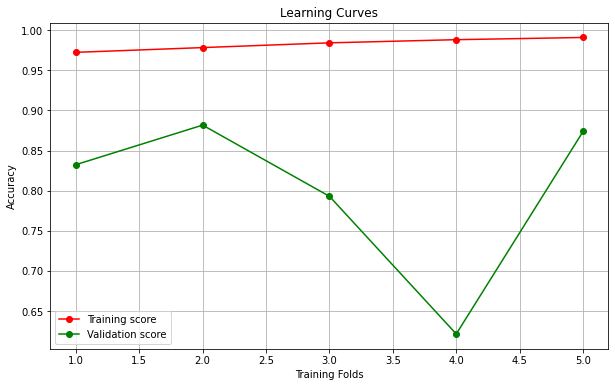

In [59]:
# Plots learning curve to check if there was overfitting
plt.figure(figsize=(10, 6))
plt.title("Learning Curves")
plt.xlabel("Training Folds")
plt.ylabel("Accuracy")
plt.grid()
plt.plot(range(1, 5 + 1), train_scores, 'o-', color="r", label="Training score")
plt.plot(range(1, 5 + 1), valid_scores, 'o-', color="g", label="Validation score")
plt.legend(loc="best")
plt.show()

In [46]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rfc = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
for x in range(2,11):
    rf_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, cv = x, verbose=2, n_jobs = 4)
    # Fit the random search model
    rf_random.fit(X_train_imputed, y_train)
    print(rf_random.best_params_)
    print (f'Train Accuracy - : {rf_random.score(X_train_imputed, y_train):.3f}')
    print (f'Test Accuracy - : {rf_random.score(X_test_imputed,y_val):.3f}')

Fitting 2 folds for each of 10 candidates, totalling 20 fits


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'n_estimators': 72, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 110, 'bootstrap': False}
Train Accuracy - : 0.942
Test Accuracy - : 0.888
Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'n_estimators': 72, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': True}
Train Accuracy - : 0.910
Test Accuracy - : 0.888
Fitting 4 folds for each of 10 candidates, totalling 40 fits


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'n_estimators': 64, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 70, 'bootstrap': False}
Train Accuracy - : 0.940
Test Accuracy - : 0.890
Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'n_estimators': 80, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}
Train Accuracy - : 0.916
Test Accuracy - : 0.890
Fitting 6 folds for each of 10 candidates, totalling 60 fits


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'n_estimators': 48, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}
Train Accuracy - : 0.923
Test Accuracy - : 0.888
Fitting 7 folds for each of 10 candidates, totalling 70 fits


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'n_estimators': 25, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 60, 'bootstrap': True}
Train Accuracy - : 0.913
Test Accuracy - : 0.852
Fitting 8 folds for each of 10 candidates, totalling 80 fits


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'n_estimators': 72, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': True}
Train Accuracy - : 0.918
Test Accuracy - : 0.893
Fitting 9 folds for each of 10 candidates, totalling 90 fits


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'n_estimators': 80, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 100, 'bootstrap': True}
Train Accuracy - : 0.918
Test Accuracy - : 0.892
Fitting 10 folds for each of 10 candidates, totalling 100 fits
{'n_estimators': 33, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}
Train Accuracy - : 0.917
Test Accuracy - : 0.882


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [47]:
rf_random.best_params_

{'n_estimators': 33,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': True}

In [48]:
print (f'Train Accuracy - : {rf_random.score(X_train_imputed, y_train):.3f}')
print (f'Test Accuracy - : {rf_random.score(X_test_imputed,y_val):.3f}')

Train Accuracy - : 0.917
Test Accuracy - : 0.882


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\missingpy\missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


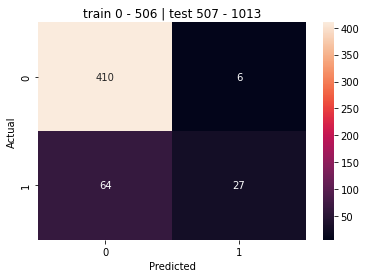

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\missingpy\missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


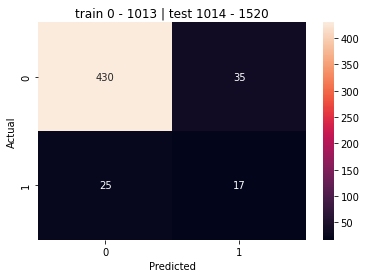

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\missingpy\missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


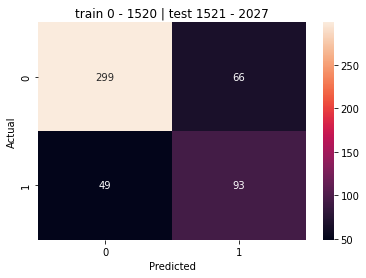

Iteration: 0
Iteration: 1


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\missingpy\missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


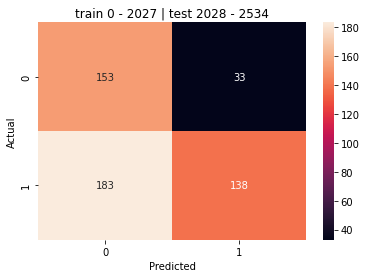

Iteration: 0
Iteration: 1


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\missingpy\missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


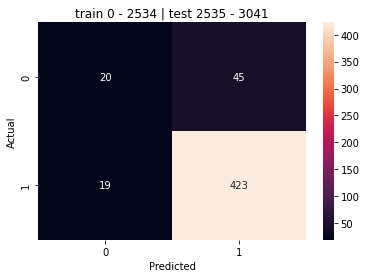

Mean Accuracy: 0.792899
[0.8619329388560157, 0.8816568047337278, 0.7731755424063116, 0.5739644970414202, 0.873767258382643]


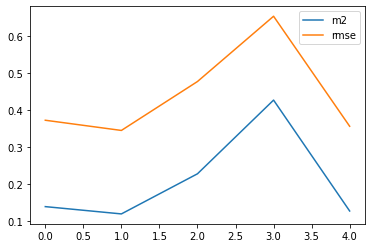

In [62]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

msquaredrf = list()
rmserf = list()
accuracyf = list()
train_scores = list()
valid_scores = list()

for train_index, val_index in cv.split(X): # Loop over the different training-test splits

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # If X_train doesn't contain any news features (this happens for earlier dates) we drop news columns from both X_train and X_test
    X_train = X_train.dropna(axis=1, how='all').copy()
    X_test = X_test[X_train.columns]
    
    #Interpolate training data to generate more training points
    X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    X_train.reset_index(level=0, drop=True, inplace=True)
    y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    y_train.reset_index(level=0, drop=True, inplace=True)

    # Interpolate testing data using the same imputer as for training data
    X_train_imputed = imputer.fit_transform(X_train.values)
    X_test_imputed = imputer.fit_transform(X_test.values)

    model = RandomForestRegressor(random_state=42).fit(X_train_imputed, np.ravel(y_train))
    y_pred = model.predict(X_test_imputed)
    y_train_pred = model.predict(X_train_imputed)
    rounded_y_pred = np.where(y_pred > 0.5, 1, 0)
    rounded_y_train_pred = np.where(y_train_pred > 0.5, 1, 0)

    m2 = mean_squared_error(y_val, rounded_y_pred)
    msquaredrf.append(m2)
    rmse = mean_squared_error(y_val, rounded_y_pred, squared=False)
    rmserf.append(rmse)
    accuracy = accuracy_score(y_val, rounded_y_pred)
    accuracyf.append(accuracy)

    train_scores.append(accuracy_score(y_train, rounded_y_train_pred))
    valid_scores.append(accuracy_score(y_val, rounded_y_pred))

    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = rounded_y_pred, true = y_val['crisis'], binary=True) # Plot confusion matrix

print(f"Mean Accuracy: {np.mean(accuracyf):.6f}") # Print MAE
print(accuracyf)

plt.plot(msquaredrf)
plt.plot(rmserf)
plt.legend(['m2', 'rmse']) 
plt.show()



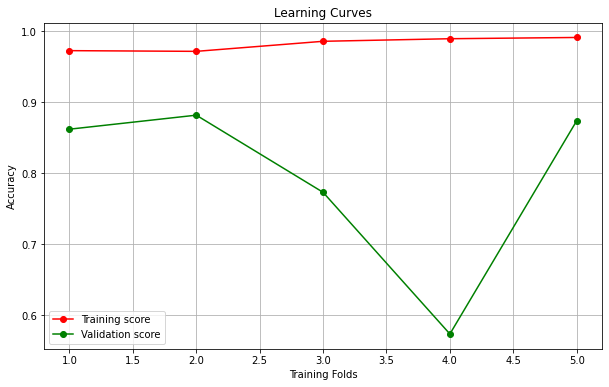

In [63]:
# Plots learning curve to check if there was overfitting
plt.figure(figsize=(10, 6))
plt.title("Learning Curves")
plt.xlabel("Training Folds")
plt.ylabel("Accuracy")
plt.grid()
plt.plot(range(1, 5 + 1), train_scores, 'o-', color="r", label="Training score")
plt.plot(range(1, 5 + 1), valid_scores, 'o-', color="g", label="Validation score")
plt.legend(loc="best")
plt.show()

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\missingpy\missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


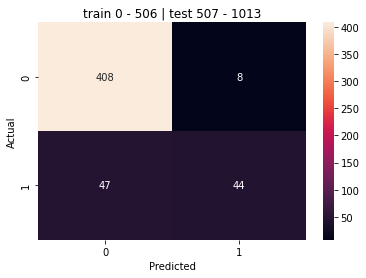

Iteration: 0
Iteration: 1
Iteration: 2


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\missingpy\missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


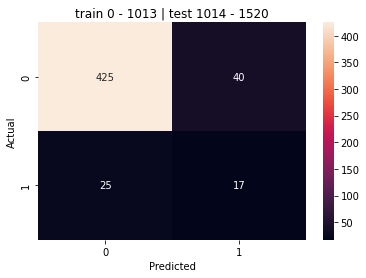

Iteration: 0
Iteration: 1


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\missingpy\missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


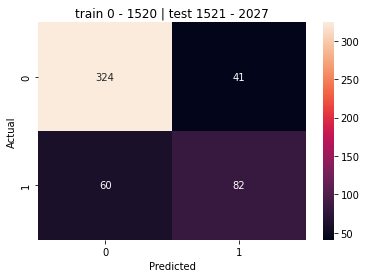

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\missingpy\missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


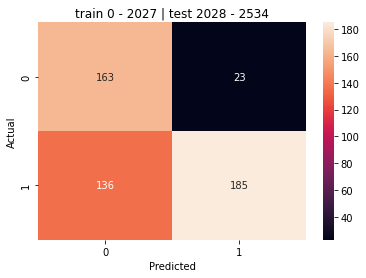

Iteration: 0
Iteration: 1
Iteration: 2


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\missingpy\missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


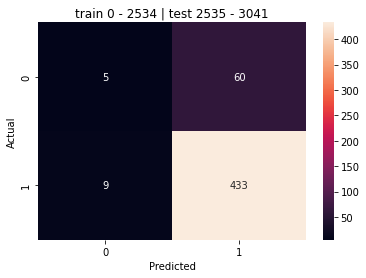

Mean Accuracy: 0.822880
[0.8915187376725838, 0.8717948717948718, 0.8007889546351085, 0.6863905325443787, 0.863905325443787]


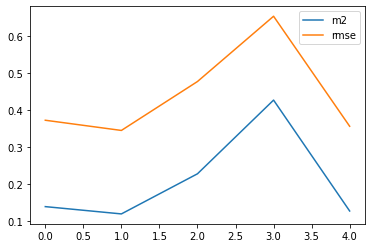

In [64]:
msquaredgb = list()
rmsegb = list()
accuracyg = list()
train_scores = list()
valid_scores = list()

for train_index, val_index in cv.split(X): # Loop over the different training-test splits

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # If X_train doesn't contain any news features (this happens for earlier dates) we drop news columns from both X_train and X_test
    X_train = X_train.dropna(axis=1, how='all').copy()
    X_test = X_test[X_train.columns]
    
    #Interpolate training data to generate more training points
    X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    X_train.reset_index(level=0, drop=True, inplace=True)
    y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    y_train.reset_index(level=0, drop=True, inplace=True)

    # Interpolate testing data using the same imputer as for training data
    X_train_imputed = imputer.fit_transform(X_train.values)
    X_test_imputed = imputer.fit_transform(X_test.values)

    model = GradientBoostingRegressor(random_state=42).fit(X_train_imputed, np.ravel(y_train))
    y_pred = model.predict(X_test_imputed)
    rounded_y_pred = np.where(y_pred > 0.5, 1, 0)
    y_train_pred = model.predict(X_train_imputed)
    rounded_y_train_pred = np.where(y_train_pred > 0.5, 1, 0)

    m2 = mean_squared_error(y_val, rounded_y_pred)
    msquaredgb.append(m2)
    rmse = mean_squared_error(y_val, rounded_y_pred, squared=False)
    rmsegb.append(rmse)
    accuracy = accuracy_score(y_val, rounded_y_pred)
    accuracyg.append(accuracy)

    train_scores.append(accuracy_score(y_train, rounded_y_train_pred))
    valid_scores.append(accuracy_score(y_val, rounded_y_pred))

    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = rounded_y_pred, true = y_val['crisis'], binary=True) # Plot confusion matrix

print(f"Mean Accuracy: {np.mean(accuracyg):.6f}") # Print MAE
print(accuracyg)

plt.plot(msquaredrf)
plt.plot(rmserf)
plt.legend(['m2', 'rmse']) 
plt.show()

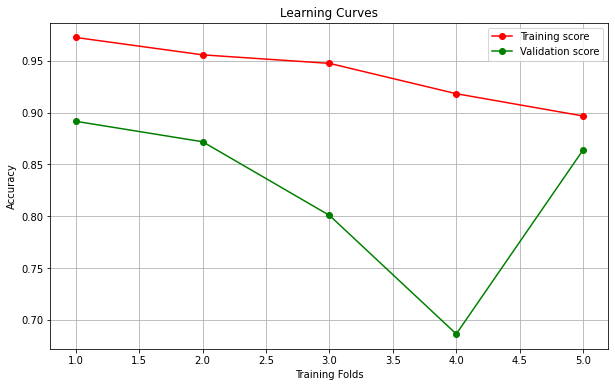

In [65]:
# Plots learning curve to check if there was overfitting
plt.figure(figsize=(10, 6))
plt.title("Learning Curves")
plt.xlabel("Training Folds")
plt.ylabel("Accuracy")
plt.grid()
plt.plot(range(1, 5 + 1), train_scores, 'o-', color="r", label="Training score")
plt.plot(range(1, 5 + 1), valid_scores, 'o-', color="g", label="Validation score")
plt.legend(loc="best")
plt.show()

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\missingpy\missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "
c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names seen at fit time, yet now missing:
- conflict
- corruption
- count_violence_lag_3
- food_price_idx_lag_3
- humanitarian
- ...

  warnings.warn(message, FutureWarning)


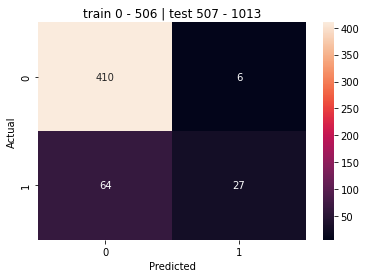

              precision    recall  f1-score   support

           0       0.86      0.99      0.92       416
           1       0.82      0.30      0.44        91

    accuracy                           0.86       507
   macro avg       0.84      0.64      0.68       507
weighted avg       0.86      0.86      0.83       507

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\missingpy\missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "
c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names seen at fit time, yet now missing:
- conflict
- corruption
- humanitarian
- hunger
- livestock
- ...

  warnings.warn(message, FutureWarning)


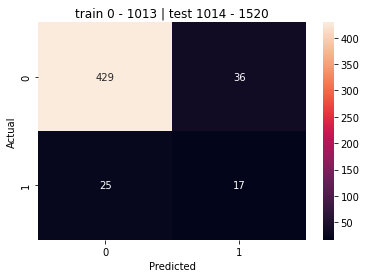

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       465
           1       0.32      0.40      0.36        42

    accuracy                           0.88       507
   macro avg       0.63      0.66      0.65       507
weighted avg       0.89      0.88      0.89       507

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\missingpy\missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "
c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names seen at fit time, yet now missing:
- conflict
- corruption
- humanitarian
- hunger
- livestock
- ...

  warnings.warn(message, FutureWarning)


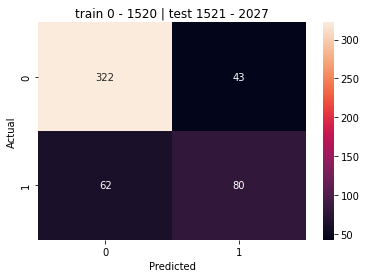

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       365
           1       0.65      0.56      0.60       142

    accuracy                           0.79       507
   macro avg       0.74      0.72      0.73       507
weighted avg       0.79      0.79      0.79       507

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\missingpy\missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "
c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names seen at fit time, yet now missing:
- conflict
- corruption
- humanitarian
- hunger
- livestock
- ...

  warnings.warn(message, FutureWarning)


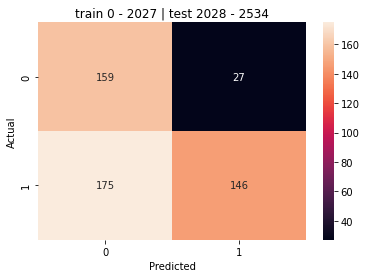

              precision    recall  f1-score   support

           0       0.48      0.85      0.61       186
           1       0.84      0.45      0.59       321

    accuracy                           0.60       507
   macro avg       0.66      0.65      0.60       507
weighted avg       0.71      0.60      0.60       507

Iteration: 0
Iteration: 1
Iteration: 2


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\missingpy\missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "
c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names seen at fit time, yet now missing:
- conflict
- corruption
- humanitarian
- hunger
- livestock
- ...

  warnings.warn(message, FutureWarning)


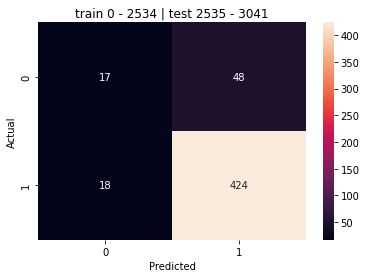

              precision    recall  f1-score   support

           0       0.49      0.26      0.34        65
           1       0.90      0.96      0.93       442

    accuracy                           0.87       507
   macro avg       0.69      0.61      0.63       507
weighted avg       0.85      0.87      0.85       507

Mean Accuracy: 0.801183
[0.8619329388560157, 0.8796844181459567, 0.7928994082840237, 0.6015779092702169, 0.8698224852071006]


<Figure size 432x288 with 0 Axes>

In [51]:
# Initinalize empty lists to score scores
accuracy_values = list()

df2 = df_copy.copy()
df2.set_index('administrative_region', append=True, inplace=True)
X_new = df2.iloc[:, -16:-1] # Define explanatory variables
X_new = sm.add_constant(X_new) # Add constant column of 1s for intercept
y_new = df2[["crisis"]] # Define target data

for train_index, val_index in cv.split(X_new): # Loop over the different training-test splits

    # Define X and y data
    X_train, X_test = X_new.iloc[train_index], X_new.iloc[val_index]
    y_train, y_val = y_new.iloc[train_index], y_new.iloc[val_index]

    # If X_train doesn't contain any news features (this happens for earlier dates) we drop news columns from both X_train and X_test
    X_train = X_train.dropna(axis=1, how='all').copy()
    X_test = X_test[X_train.columns]

    #Interpolate training data to generate more training points
    X_train = X_train.groupby('administrative_region', as_index=False).apply(lambda group: group.interpolate())
    X_train.reset_index(level=0, drop=True, inplace=True)
    y_train = y_train.groupby('administrative_region', as_index=False).apply(lambda group: group.interpolate())
    y_train.reset_index(level=0, drop=True, inplace=True)

    # Interpolate testing data using the same imputer as for training data
    X_train_imputed = imputer.fit_transform(X_train.values)
    X_test_imputed = imputer.fit_transform(X_test.values)

    # Train the RandomForestClassifier
    # number of trees is 100, and  42 is just to initialize random number to make random choices during training
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    results = rf_classifier.fit(X=X_train_imputed, y=np.ravel(y_train))

    rf_classifier.feature_names_in_ = list(X.columns)

    # Predict on the test data
    y_pred = rf_classifier.predict(X_test)
    
    accuracy = accuracy_score(y_val, y_pred)
    accuracy_values.append(accuracy)

    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['crisis'], binary=True) # Plot confusion matrix

    print (classification_report(y_val,y_pred))


print(f"Mean Accuracy: {np.mean(accuracy_values):.6f}") # Print MAE
print(accuracy_values)